In [52]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional
from keras.layers.convolutional import Conv1D, MaxPooling1D

from numpy.random import seed
seed(1)

import tensorflow as tf
tf.random.set_seed(2)

In [42]:
# Function to create data with timesteps

def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)):
		end_ix = i + n_steps
		if end_ix > len(data):
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix-1, -1]  #last column is the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [43]:
# Load the data

data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')

m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel()})    # TTF and TSF not used
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'A_filt':data['A_filt'].ravel(), 'V_filt':data['V_filt'].ravel(),
                    'T_pc':data['T_pc'].ravel(), 'Vel_pc':data['Vel_pc'].ravel(), 'T_der':data['T_der'].ravel(), 'Vel_der':data['Vel_der'].ravel()})
                   # 'T_off':data['T_off'].ravel(), 'Vel_off':data['Vel_off'].ravel()})    # 7 features

df = a_t.merge(m_t, on='Time')
df = df.drop(['Time'], axis=1)

'''
# Create new features
df['A_2'] = np.sqrt(df['A_filt']);
df['V_2'] = np.sqrt(df['V_filt']);
df = df[['A_filt', 'V_filt', 'T_pc', 'Vel_pc', 'T_der', 'Vel_der', 'A_2', 'V_2', 'SS']]
'''

arr = df.to_numpy()
n_steps = 3
n_features = df.shape[1]-1
xdf, ydf = create_timesteps(arr, n_steps)
print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))

Features shape, X =  (132397, 3, 6)
Target shape, Y =  (132397,)


In [44]:
# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)
print("Training:", np.shape(X_train))
print("Validation:", np.shape(X_val))
print("Testing:", np.shape(x_test))

Training: (95325, 3, 6)
Validation: (10592, 3, 6)
Testing: (26480, 3, 6)


Train on 95325 samples, validate on 10592 samples
Epoch 1/30
95325/95325 [==============================] - 42s 438us/step - loss: 49.0374 - val_loss: 5.3937
Epoch 2/30
95325/95325 [==============================] - 41s 432us/step - loss: 3.2818 - val_loss: 2.1948
Epoch 3/30
95325/95325 [==============================] - 41s 430us/step - loss: 1.4375 - val_loss: 0.0208
Epoch 4/30
95325/95325 [==============================] - 41s 429us/step - loss: 0.0461 - val_loss: 0.0583
Epoch 5/30
95325/95325 [==============================] - 41s 430us/step - loss: 0.0410 - val_loss: 0.0224
Epoch 6/30
95325/95325 [==============================] - 41s 432us/step - loss: 0.0240 - val_loss: 0.0644
Epoch 7/30
95325/95325 [==============================] - 41s 431us/step - loss: 0.0289 - val_loss: 0.0204
Epoch 8/30
95325/95325 [==============================] - 42s 440us/step - loss: 0.0155 - val_loss: 0.0214
Epoch 9/30
95325/95325 [==============================] - 41s 430us/step - loss: 0.0162 - val

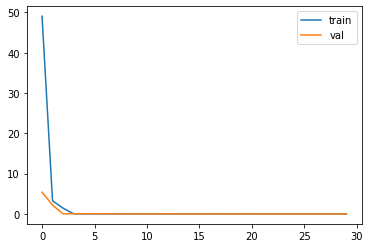

In [57]:
# Build the model

model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(TimeDistributed(Dense(256, activation='relu')))
model.add(Flatten())
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_data=(X_val, Y_val), verbose=1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [58]:
# Evaluate the model

y_predTrain = model.predict(X_train)
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

y_predVal = model.predict(X_val)
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))  

y_predTest = model.predict(x_test)
test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

print("R^2 scores: ", train_r2, val_r2, test_r2)
print("RMSE: ", train_rmse, val_rmse, test_rmse)

R^2 scores:  0.651240313640606 0.5492370390465406 0.48512357155361774
RMSE:  0.07590346613226741 0.09817012962706748 0.10392149304252511


In [47]:
# Save the model

print(model.summary())
model.save('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/models/LSTM1.h5')

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 3, 512)            1062912   
_________________________________________________________________
time_distributed_9 (TimeDist (None, 3, 512)            262656    
_________________________________________________________________
flatten_9 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 1537      
Total params: 1,327,105
Trainable params: 1,327,105
Non-trainable params: 0
_________________________________________________________________
None


Text(0.5, 1.0, 'Testing data')

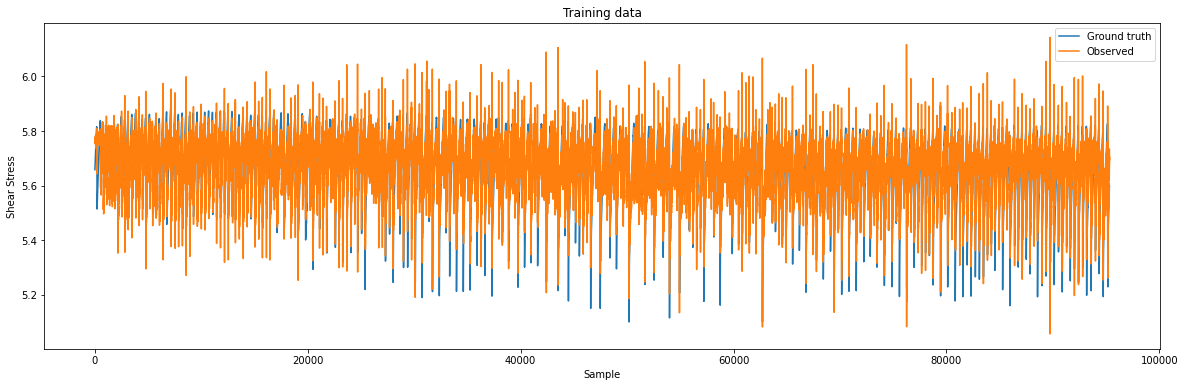

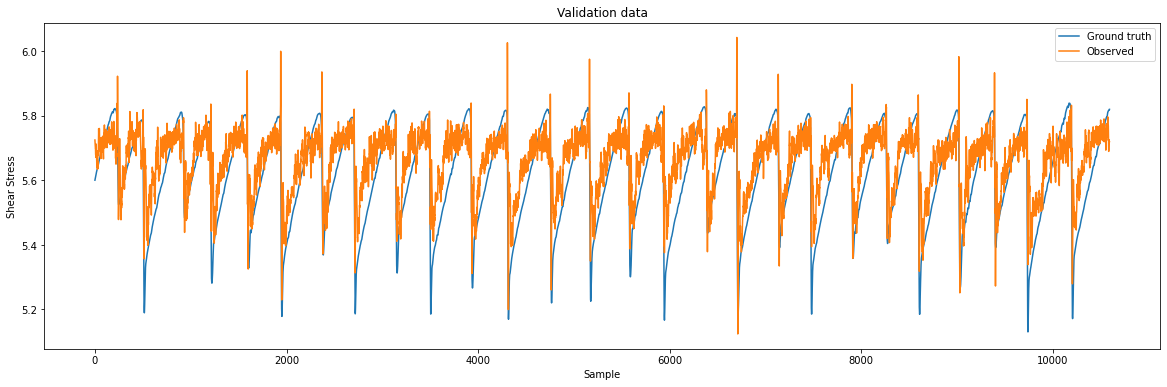

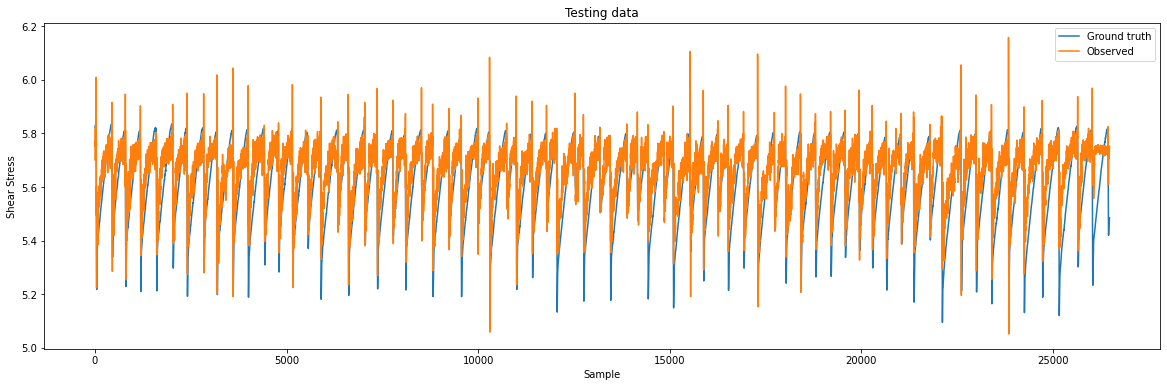

In [59]:
# Results plot

fig = plt.figure(1, figsize=(20,6))
plt.plot(Y_train)
plt.plot(y_predTrain)
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Observed'])
plt.title('Training data')

fig = plt.figure(2, figsize=(20,6))
plt.plot(Y_val)
plt.plot(y_predVal)
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Observed'])
plt.title('Validation data')

fig = plt.figure(3, figsize=(20,6))
plt.plot(y_test)
plt.plot(y_predTest)
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Observed'])
plt.title('Testing data')


Text(0.5, 1.0, '5000 Samples, Testing Data')

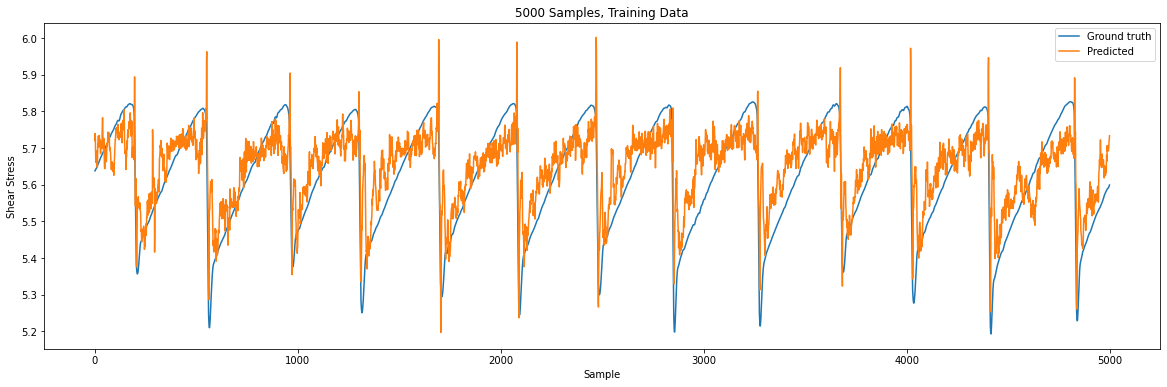

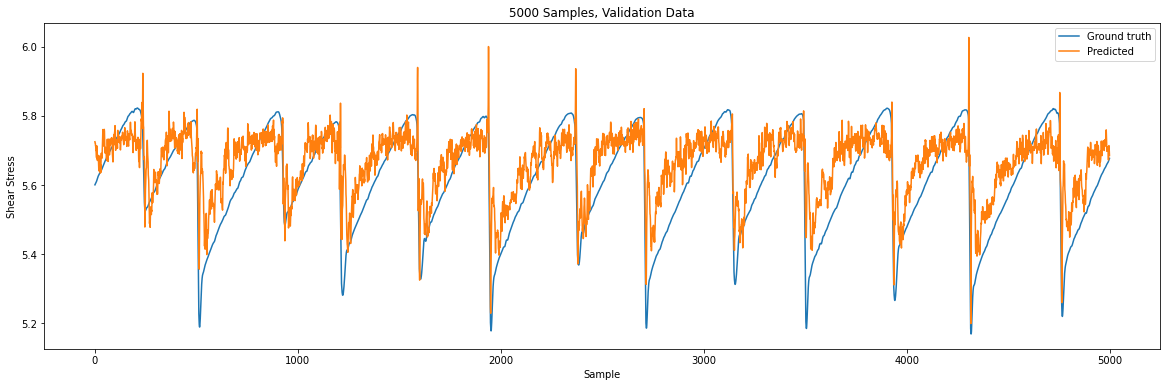

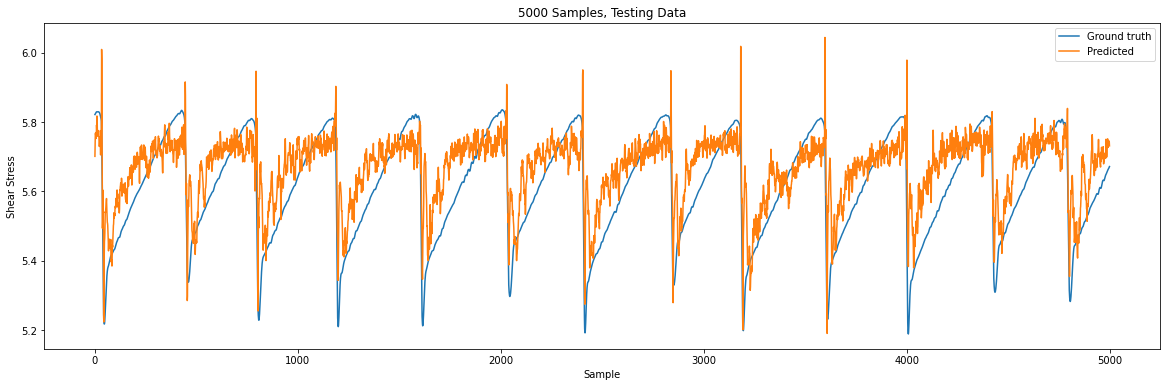

In [60]:
# Detailed view of the plots

fig = plt.figure(4, figsize=(20,6))
plt.plot(Y_train[-5000:])
plt.plot(y_predTrain[-5000:])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('5000 Samples, Training Data')

fig = plt.figure(5, figsize=(20,6))
plt.plot(Y_val[:5000])
plt.plot(y_predVal[:5000])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('5000 Samples, Validation Data')

fig = plt.figure(6, figsize=(20,6))
plt.plot(y_test[:5000])
plt.plot(y_predTest[:5000])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('5000 Samples, Testing Data')
